### TODO:

* try neewer version of spacy (e.g. different add_pipe syntax) - better dep_prser?
* non-human character gender count (versus human) - better aggregation
* add all female/male subjects (singular and plural) to verb clause detection e.g. ['she', 'girl', 'woman', 'mum', 'mother', 'lady', 'sister', 'daughter']
* for found words, store in dataframe instead of lists (with metadata: character it relates to, book found in etc)
* make tables for all word types
* make wordlcouds

### TO DISCUSS:
* other sentence structures to capture?
* need validation?

### Other ideas:
* how often does he/she appear as subject/object of verb clause?

### Resources:

- https://github.com/peter3125/enhanced-subject-verb-object-extraction (better than standard Spacy for subject-verb-object extraction)
- https://nbviewer.jupyter.org/gist/nealcaren/5105037 (how the Times writes about men and women)
- https://spacy.io/usage/linguistic-features
- https://stackoverflow.com/questions/40288323/what-do-spacys-part-of-speech-and-dependency-tags-mean

In [1]:
import os
import pdfplumber
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import spacy
from spacy import displacy
from spacy.lang.en.examples import sentences 

%matplotlib inline

In [2]:
nlp = spacy.load("en_core_web_lg")
#nlp.add_pipe(nlp.create_pipe('sentencizer'))
#nlp.add_pipe(nlp.create_pipe("parser"))

In [3]:
doc = nlp("She eats the apple hungrily")
#doc = nlp("He was lazy")

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

She -PRON- PRON PRP nsubj Xxx True True
eats eat VERB VBZ ROOT xxxx True False
the the DET DT det xxx True True
apple apple NOUN NN dobj xxxx True False
hungrily hungrily ADV RB advmod xxxx True False


In [4]:
displacy.render(doc, style="dep", options={'distance':120});

In [5]:
spacy.explain('dobj')

'direct object'

In [6]:
#labels = pd.read_excel('../Book List Exel April.xlsx', sheet_name='Sheet1')
labels = pd.read_excel('../Book List Clean Titles.xlsx', sheet_name='Sheet1')
labels = labels.rename(columns={'Author ': 'Author'})
#labels.loc[labels.Title=='The Gruffalo']

In [7]:
os.chdir('../text_pdfs')

In [8]:
df = pd.DataFrame()

def grab_text(title, labels):
    
    start = labels.loc[labels.Title==title]['Starting Page']
    if len(start)==0:
        print(title, "no start")
        start = 0
    else:
        start = start.values[0]
    end = labels.loc[labels.Title==title]['Ending Page']
    if len(end)==0:
        print(title, "no end")
        end = 0
    else:
        end = end.values[0]
    
    title = title + '.pdf'
    all_text = ''
    with pdfplumber.open(title) as pdf:
        for i, page in enumerate(pdf.pages):
            if i+1 >= start and i < end:
                single_page_text = page.extract_text()

                if single_page_text is not None:
                    all_text = all_text + '\n' + single_page_text
                
    return all_text

df['Title'] = [file.split('.')[0] for file in os.listdir() if file.split('.')[1]=='pdf']
df['Text'] = [grab_text(title, labels) for title in df.Title]

In [9]:
df.head()

,Title,Text
0,The Night Before Christmas,\n'Twas the night before Christmas\nwhen all t...
1,The Gruffalo,\nA mouse took a stroll through the deep dark ...
2,The Monstrous Tale of Celery Crumble,\nHave you met Celery Crumble?\nThat’s her rig...
3,Peace at Last,"\nThe hour was late.\nMr Bear was tired, Mrs B..."
4,Barry The Fish With Fingers,"\nPuffy the puffer fish, could blow\nthe BEST ..."


In [10]:
len(df)

129

#### Fix this to get the Gruffalo!

In [11]:
test = df.loc[0].Text.replace('\n', ' ').replace('  ', ' ')
#test[0:50]
test[51:98]

'the house Not a creature was stirring, not even'

#### This is an example of it failing (mouse should be dobj in this sentence):

Note: would this work better https://github.com/peter3125/enhanced-subject-verb-object-extraction

In [12]:
doc = nlp(test[51:98])
#doc = nlp(test[0:50])
#doc = nlp(test)

# for token in doc:
#     print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
#             token.shape_, token.is_alpha, token.is_stop)

In [13]:
displacy.render(doc, style="dep", options={'distance':100});

#### So, we want to get any he/she that appears, and the verbs and nouns that are associated with them.

#### Then we will extend to use named entities also (with named characeters and their genders from the excel sheet).

Other ideas:
- get noun chunks
- get adjectival modifiers (child of noun) for gendered nouns
- get nsubj for each verb
- get dobj for verbs with gendered nsubj

In [14]:
female_identifiers =['she', 'girl', 'woman', 'mum', 'mother', 'lady', 'sister', 'daughter',
                   'girls', 'women', 'mums', 'mothers', 'ladies', 'sisters', 'daughters']

male_identifiers = ['he', 'boy', 'man', 'dad', 'father', 'guy', 'brother', 'son',
                   'boys', 'men', 'dads', 'fathers', 'guys', 'brothers', 'sons']


In [15]:
doc = nlp(test)

In [16]:
test_female_verbs = list()
test_male_verbs = list()

for title, text in zip(df.Title, df.Text):
    text = ' '.join(text.replace('\n', ' ').split())
    doc = nlp(text)

    for possible_subject in doc:
            if possible_subject.dep_ == 'nsubj' and possible_subject.head.pos_ == 'VERB':
                
                if possible_subject.head.lemma_ == "’":
                    #print(possible_subject.head, [child for child in possible_subject.head.children])
                    #print(title)
                    lem = 'be'
                else:
                    lem = possible_subject.head.lemma_
                    
                #if possible_subject.lower_ == 'he':
                if possible_subject.lower_ in male_identifiers:
                    test_male_verbs.append(lem)
                #elif possible_subject.lower_ == 'she':    
                elif possible_subject.lower_ in female_identifiers:    
                    test_female_verbs.append(lem)

In [17]:
print(len(test_male_verbs))
print(len(test_female_verbs))

# with 70 books it was 757 and 249

1278
423


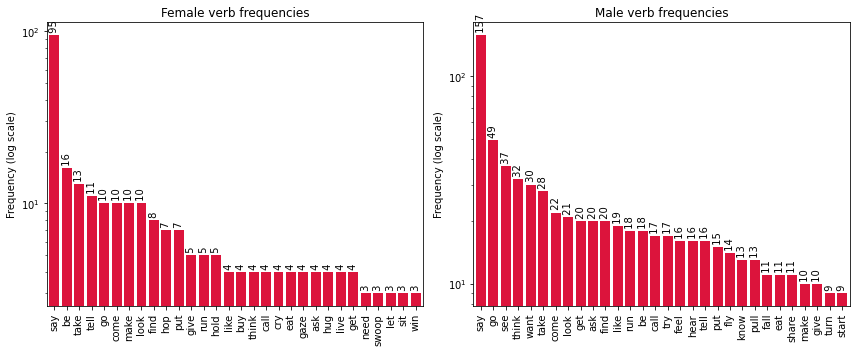

In [18]:
N = 30

def bar_word_freqs(word_list, title, N=N):
    vf = Counter(word_list)
    total = int(sum(vf.values()))
    y = [count for tag, count in vf.most_common(N)]
    x = [tag for tag, count in vf.most_common(N)]

    plt.bar(x, y, color='crimson')
    plt.title(title)
    plt.ylabel("Frequency (log scale)")
    plt.yscale('log')
    plt.xticks(rotation=90)
    for i, (tag, count) in enumerate(vf.most_common(N)):
        plt.text(i, count, f' {count} ', rotation=90,
                 ha='center', va='bottom', 
                 color='black')
#                  ha='center', va='top' if count < 6 else 'bottom', 
#                  color='white' if count < 6 else 'black')
    plt.xlim(-0.6, len(x)-0.4)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
bar_word_freqs(test_female_verbs, "Female verb frequencies")

plt.subplot(1,2,2)
bar_word_freqs(test_male_verbs, "Male verb frequencies")

plt.tight_layout()

#### Now we do the same, but including the named characters.

And we extract the following words (see diagrams below):
- verb associated with the noun subject in each sentence (nsubj)
- adverbs associated with that verb (advmod)
- nouns that are the object of the verb (dobj)
- adjectives associated with the noun subject (amod and acomp)

#### To clarify the word types:

In [19]:
demo_sentence = "She ate the dark chocolate hungrily."
doc = nlp(demo_sentence)
displacy.render(doc, style="dep", options={'distance':120});

In [20]:
demo_sentence = "The fat mouse looked good."
doc = nlp(demo_sentence)
displacy.render(doc, style="dep", options={'distance':120});

In [21]:
labels['Protagonist Gender'].unique()

array([nan, 'F/M/M', 'M', 'NGS PLURAL', 'M/M', 'F', 'NGS FIRST PERSON',
       'F/F/F/M/M/M/M PLURAL', 'NA ', 'M ', 'NGS', 'F/M',
       'M/F/F/M/F/M/F/F/M', 'M PLURAL ', 'M  ', 'NA 2nd Person', 'M/F ',
       '2nd person voice/NGS', 'NGS/NGS ', 'NA plural', 'F ',
       'M/NGS/NGS/NGS/NGS', 'NA First Person', 'M/F', 'Many NGS',
       'NGS SINGULAR AND PLURAL', 'NGS MANY'], dtype=object)

In [22]:
labels['Protagonist Name'].unique()

array([nan, 'Sarah/Percy/Bill', 'Eddy', 'we', 'Mr Bear; Gruff the Grump',
       'Percy', 'Big Bear/Little Bear', 'Father Christmas', 'I/We',
       'Grinch ', 'Santa', 'Mary', 'I', 'innkeeper', 'shepherd boy',
       'little dove',
       'cow/Mrs Hen/Goldilocks/Johnny/Peter/Paul/firemen;fireman',
       'Elmer', 'Cinder', 'Marlon', 'Jake', 'Sir Charlie ', 'Crossfire',
       'Harry', 'monkey', 'snail / whale', 'McTat ', 'witch', 'Superworm',
       'Mouse', "Gruffalo's child", 'Charlie Cook', 'Norman', 'duck',
       'Tom thumb/Mother Hubbard/Cinderella/Baby Bunting/Bo-peep/Jack/Jill/Wicked Witch/Robin Hood',
       'Sid', 'dinos;dinosaurs/cavemen', 'Kipper', 'you',
       'Matilda; Tilda', 'Postman', 'Dave/Dogger', 'boy', 'boy/penguin',
       'Supertato', 'Baby bear', 'Arthur', 'Kipper ', 'Mr Bear',
       'Mr Large/Mrs Large', 'Wibbly Pig; Wibbly', 'dog/frog',
       'the farmer', 'ladybird', 'Squash', 'caterpillar', 'Caterpillars',
       'spider', 'Scramble', 'ladybird/it', 'but

In [23]:
female_verbs = list()
male_verbs = list()

female_ads = list()
male_ads = list()

female_advs = list()
male_advs = list()

female_nouns = list()
male_nouns = list()

def add_words(noun, adv, adj, noun_list, adv_list, adj_list):
    if noun is not None:
        noun_list.append(noun)
    if adv is not None:
        adv_list.append(adv)
    if adj is not None:
        adj_list.append(adj)
        
    return noun_list, adv_list, adj_list

for title, text in zip(df.Title, df.Text):
    text = text.replace('\n', ' ')
    doc = nlp(text)
    
    protagonist = labels.loc[labels.Title==title]['Protagonist Name'].values
    protagonist_gender = labels.loc[labels.Title==title]['Protagonist Gender'].values

    for possible_subject in doc:
            if possible_subject.dep_ == 'nsubj' and possible_subject.head.pos_ == 'VERB':
                
                if possible_subject.head.lemma_ == "’":
                    #print(possible_subject.head, [child for child in possible_subject.head.children])
                    #print(title)
                    lem = 'be'
                else:
                    lem = possible_subject.head.lemma_
                    
                noun = None
                adv = None
                adj = None
                for child in possible_subject.head.children:
                    if child.dep_ == 'dobj':
                        noun = child.lower_ #.lemma_
                    elif child.dep_ == 'acomp':
                        adj = child.lower_ #.lemma_
                    elif child.dep_ == 'advmod':
                        adv = child.lower_ #.lemma_
                    
                if possible_subject.lower_ in male_identifiers:
                    male_verbs.append(lem)
                    male_nouns, male_advs, male_ads = add_words(noun, adv, adj, male_nouns, male_advs, male_ads)
                    
                elif possible_subject.lower_ in female_identifiers:    
                    female_verbs.append(lem)
                    female_nouns, female_advs, female_ads = add_words(noun, adv, adj, female_nouns, female_advs, female_ads)
                    
                if len(protagonist) == 1 and isinstance(protagonist[0], str):
                    protagonist = protagonist[0].split('/')
                    protagonist_gender = protagonist_gender[0].split('/')
                    
                    for p, pg in zip(protagonist, protagonist_gender):
                        #print(p, pg)
                        if possible_subject.lower_ == p.lower():
                            if pg == 'M':
                                male_verbs.append(lem)
                                male_nouns, male_advs, male_ads = add_words(noun, adv, adj, male_nouns, male_advs, male_ads)
                            elif pg == 'F':
                                female_verbs.append(lem)
                                female_nouns, female_advs, female_ads = add_words(noun, adv, adj, female_nouns, female_advs, female_ads)
#                 if not(np.isnan(protagonist) and np.isnan(protagonist_gender)):
#                     if len(protagonist_gender.split('/')) == 1:
                        

In [24]:
print("Without named protagonists we had: %d female verbs and %d male verbs." % (len(test_female_verbs), len(test_male_verbs)))
print("Now, with named protagonists we had: %d female verbs and %d male verbs." % (len(female_verbs), len(male_verbs)))

print("We also have:")

print("%d female adverbs and %d male adverbs" %(len(female_advs), len(male_advs)))
print("%d female adjectives and %d male adjectives" %(len(female_ads), len(male_ads)))
print("%d female nouns and %d male noun" %(len(female_nouns), len(male_nouns)))


Without named protagonists we had: 423 female verbs and 1278 male verbs.
Now, with named protagonists we had: 493 female verbs and 1973 male verbs.
We also have:
114 female adverbs and 484 male adverbs
14 female adjectives and 55 male adjectives
157 female nouns and 575 male noun


#### Normalising by the number of characters:

Note: these numbers are computed in intial_analysis notebook

In [35]:
total_females = 114
total_males = 243

In [36]:
print(len(female_verbs) / total_females, len(female_verbs))
print(len(male_verbs) / total_males, len(male_verbs))

print(len(female_nouns) / total_females, len(female_nouns))
print(len(male_nouns) / total_males, len(male_nouns))

print(len(female_advs) / total_females, len(female_advs))
print(len(male_advs) / total_males, len(male_advs))

print(len(female_ads) / total_females, len(female_ads))
print(len(male_ads) / total_males, len(male_ads))

4.324561403508772 493
8.119341563786008 1973
1.3771929824561404 157
2.366255144032922 575
1.0 114
1.991769547325103 484
0.12280701754385964 14
0.22633744855967078 55


#### Previously with 70 books these numbers were: 

Without named protagonists we had: 249 female verbs and 757 male verbs.
Now, with named protagonists we had: 293 female verbs and 1157 male verbs.
We also have:
58 female adverbs and 278 male adverbs
6 female adjectives and 42 male adjectives
87 female nouns and 372 male noun


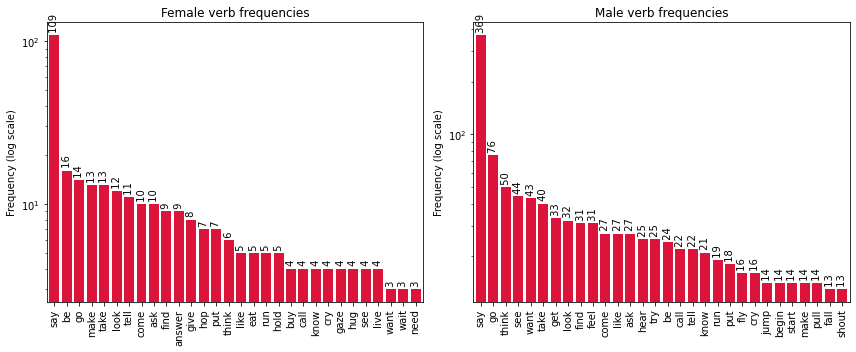

In [25]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
bar_word_freqs(female_verbs, "Female verb frequencies")

plt.subplot(1,2,2)
bar_word_freqs(male_verbs, "Male verb frequencies")

plt.tight_layout()

In [26]:
dict(Counter(female_verbs))

{'go': 14,
 'say': 109,
 'think': 6,
 'make': 13,
 'invite': 1,
 'want': 3,
 'paint': 1,
 'find': 9,
 'wait': 3,
 'unscrew': 1,
 'enjoy': 1,
 'learn': 2,
 'need': 3,
 'surprise': 1,
 'like': 5,
 'thank': 1,
 'come': 10,
 'buy': 4,
 'take': 13,
 'help': 2,
 'call': 4,
 'arch': 1,
 'swoop': 3,
 'lift': 1,
 'sing': 1,
 'let': 3,
 'hoot': 1,
 'coo': 1,
 'sleep': 2,
 'know': 4,
 'fly': 2,
 'hop': 7,
 'cry': 4,
 'laugh': 1,
 'gasp': 1,
 'lead': 1,
 'jump': 2,
 'disappear': 1,
 'crash': 1,
 'be': 16,
 'tie': 1,
 'sit': 3,
 'eat': 5,
 'weigh': 1,
 'gaze': 4,
 'notice': 2,
 'teach': 1,
 'show': 1,
 'give': 8,
 'look': 12,
 'search': 1,
 'turn': 2,
 'win': 3,
 'keep': 3,
 'listen': 1,
 'hear': 3,
 'run': 5,
 'walk': 2,
 'hold': 5,
 'start': 1,
 'catch': 2,
 'stop': 3,
 'ask': 10,
 'hug': 4,
 'bite': 2,
 'chop': 1,
 'sniff': 1,
 'tiptoe': 3,
 'tell': 11,
 'speak': 1,
 'decorate': 1,
 'whisper': 2,
 'put': 7,
 'try': 2,
 'count': 3,
 'meet': 1,
 'lose': 1,
 'hiss': 1,
 'slither': 2,
 'open': 3,
 '

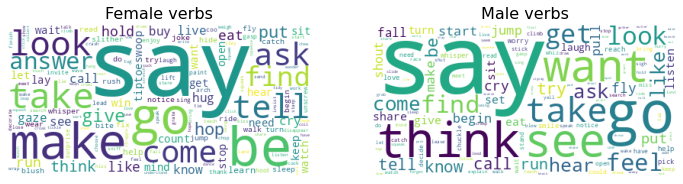

In [27]:
tfs = 16

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Female verbs', fontsize=tfs)
wc = WordCloud(background_color='white').generate_from_frequencies(Counter(female_verbs))
plt.imshow(wc)
plt.axis('off');

plt.subplot(1,2,2)
plt.title('Male verbs', fontsize=tfs)
wc = WordCloud(background_color='white').generate_from_frequencies(Counter(male_verbs))
plt.imshow(wc)
plt.axis('off');

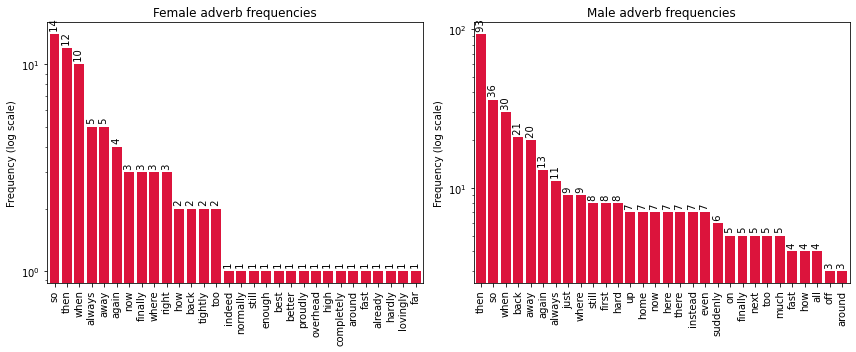

In [45]:
# ft = "Female noun frequencies"
# mt = "Male noun frequencies"
# fw = female_nouns
# mw = male_nouns

# ft = "Female adjective frequencies"
# mt = "Male adjective frequencies"
# fw = female_ads
# mw = male_ads

ft = "Female adverb frequencies"
mt = "Male adverb frequencies"
fw = female_advs
mw = male_advs

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
bar_word_freqs(fw, ft)

plt.subplot(1,2,2)
bar_word_freqs(mw, mt)

plt.tight_layout()

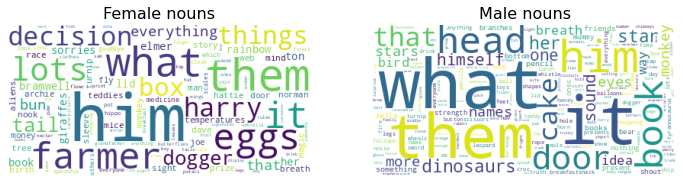

In [29]:
tfs = 16

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Female nouns', fontsize=tfs)
wc = WordCloud(background_color='white').generate_from_frequencies(Counter(female_nouns))
plt.imshow(wc)
plt.axis('off');

plt.subplot(1,2,2)
plt.title('Male nouns', fontsize=tfs)
wc = WordCloud(background_color='white').generate_from_frequencies(Counter(male_nouns))
plt.imshow(wc)
plt.axis('off');

In [30]:
Counter(female_verbs).most_common(20)

[('say', 109),
 ('be', 16),
 ('go', 14),
 ('make', 13),
 ('take', 13),
 ('look', 12),
 ('tell', 11),
 ('come', 10),
 ('ask', 10),
 ('find', 9),
 ('answer', 9),
 ('give', 8),
 ('hop', 7),
 ('put', 7),
 ('think', 6),
 ('like', 5),
 ('eat', 5),
 ('run', 5),
 ('hold', 5),
 ('buy', 4)]

#### Adjectival modifiers:

In [31]:
#demo_sentence = "All the people said very good, clever boy!"
demo_sentence = "Their new baby brother"
doc = nlp(demo_sentence)
displacy.render(doc, style="dep", options={'distance':120});

In [32]:
female_adjs = list()
male_adjs = list()

for title, text in zip(df.Title, df.Text):
    text = text.replace('\n', ' ')
    doc = nlp(text)
    
    protagonist = labels.loc[labels.Title==title]['Protagonist Name'].values
    protagonist_gender = labels.loc[labels.Title==title]['Protagonist Gender'].values

    for possible_amod in doc:
            if possible_amod.dep_ == 'amod' and possible_amod.head.pos_ == 'NOUN':
                
#                 if possible_subject.head.lemma_ == "’":
#                     #print(possible_subject.head, [child for child in possible_subject.head.children])
#                     #print(title)
#                     lem = 'be'
#                 else:
#                     lem = possible_subject.head.lemma_
                lem = possible_amod.lemma_
                    
                if possible_amod.head.lower_ in male_identifiers:
                    male_adjs.append(lem)
                    #print(possible_amod.sent)
                    #print(possible_amod.head.lower_, lem)
                elif possible_amod.head.lower_ in female_identifiers:    
                    female_adjs.append(lem)
                    #print(possible_amod.head.lower_, lem)
                    
                if len(protagonist) == 1 and isinstance(protagonist[0], str):
                    protagonist = protagonist[0].split('/')
                    protagonist_gender = protagonist_gender[0].split('/')
                    
                    for p, pg in zip(protagonist, protagonist_gender):
                        if possible_amod.head.lower_ == p.lower():
                            #print(p.lower(), lem)
                            if pg == 'M':
                                male_adjs.append(lem)
                            elif pg == 'F':
                                female_adjs.append(lem)

                        

In [33]:
print(len(female_adjs))
print(len(male_adjs))

53
47


In [34]:
Counter(male_adjs).most_common(20)

[('little', 19),
 ('old', 5),
 ('wise', 5),
 ('brown', 3),
 ('scary', 2),
 ('good', 2),
 ('new', 2),
 ('young', 1),
 ('clever', 1),
 ('cheeky', 1),
 ('small', 1),
 ('green', 1),
 ('special', 1),
 ('wet', 1),
 ('asleep', 1),
 ('grumpy', 1)]

In [35]:
Counter(female_adjs).most_common(20)

[('little', 17),
 ('lazy', 11),
 ('old', 8),
 ('young', 3),
 ('poor', 2),
 ('naughty', 1),
 ('bossy', 1),
 ('big', 1),
 ('thin', 1),
 ('most', 1),
 ('bad', 1),
 ('ugly', 1),
 ('silly', 1),
 ('tiny', 1),
 ('sweet', 1),
 ('asleep', 1),
 ('normal', 1)]

#### Including the adjectives from the previous caluse type (amod and acmop relating the nsubj)

In [42]:
fa = female_adjs + female_ads
ma = male_adjs + male_ads

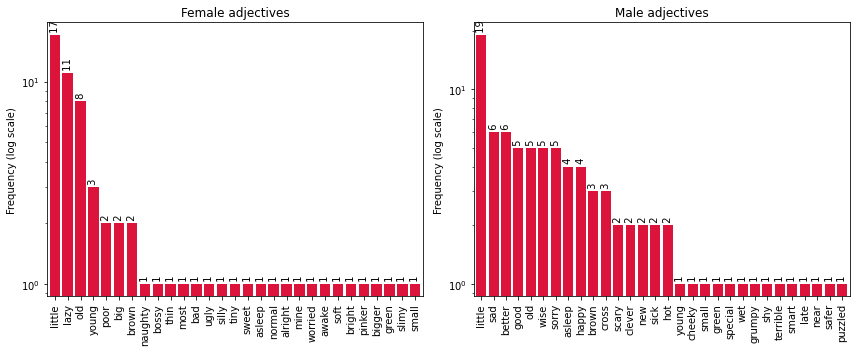

In [44]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
bar_word_freqs(fa, "Female adjectives")

plt.subplot(1,2,2)
bar_word_freqs(ma, "Male adjectives")

plt.tight_layout()

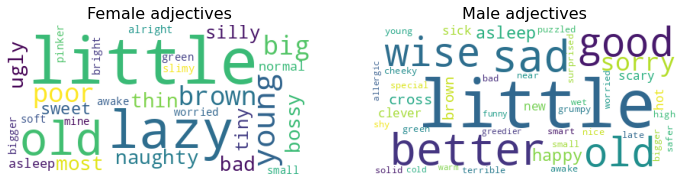

In [43]:
tfs = 16

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Female adjectives', fontsize=tfs)
wc = WordCloud(background_color='white').generate_from_frequencies(Counter(fa))
plt.imshow(wc)
plt.axis('off');

plt.subplot(1,2,2)
plt.title('Male adjectives', fontsize=tfs)
wc = WordCloud(background_color='white').generate_from_frequencies(Counter(ma))
plt.imshow(wc)
plt.axis('off');

### Things to resolve:

1. Plural genders (e.g. cavemen)
2. Double barrel names (e.g. Stick Man, Charlie Cook etc)- replace with single token? (e.g. Stick_Man)
3. Add his/hers e.g. "His favourite food is roasted fox"
4. Add recognition of who is speaking. e.g. "I'm going to have lunch with a gruffalo"

Need to do proper NER rather than just using nsubj?

#### Examples of sentence structures that are not currently being detected:

In [40]:
demo_sentence = "Charlie Cook was very hungry."
doc = nlp(demo_sentence)
displacy.render(doc, style="dep", options={'distance':120});

In [41]:
demo_sentence = "His favourite food is roasted fox."
doc = nlp(demo_sentence)
displacy.render(doc, style="dep", options={'distance':120});

In [42]:
demo_sentence = "It wasn't her best idea."
doc = nlp(demo_sentence)
displacy.render(doc, style="dep", options={'distance':120});

In [43]:
demo_sentence = "She said: 'I'm hungry.'"
doc = nlp(demo_sentence)
displacy.render(doc, style="dep", options={'distance':120});

In [44]:
demo_sentence = "He was in the kitchen."
doc = nlp(demo_sentence)
displacy.render(doc, style="dep", options={'distance':120});

### Looking at speech:

In [45]:
for title, text in zip(df.Title, df.Text):
    text = text.replace('\n', ' ')
    doc = nlp(text)
    sentence_list = list(doc.sents)
    
    protagonist = labels.loc[labels.Title==title]['Protagonist Name'].values
    protagonist_gender = labels.loc[labels.Title==title]['Protagonist Gender'].values

    for possible_subject in doc:
            if possible_subject.dep_ == 'nsubj' and possible_subject.head.pos_ == 'VERB':
                
                if possible_subject.head.lemma_ == "say":
                    print('pre-previous:', sentence_list[sentence_list.index(possible_subject.sent)-2])
                    print('previous:', sentence_list[sentence_list.index(possible_subject.sent)-1])
                    print('current:', possible_subject.head.sent)
                    print('next:', sentence_list[sentence_list.index(possible_subject.sent)+1])
                    print(' ')
                    

pre-previous: “Roasted fox!
previous: I’m off!”
current: Fox said.   
next: “Goodbye, little mouse," and away he sped.   
 
pre-previous: It’s    a gruffalo!" .
previous: “My favourite food!"
current: the Gruffalo said.
next: “You'll    taste good on a slice of bread!”   
 
pre-previous: the Gruffalo said.
previous: “You'll    taste good on a slice of bread!”   
current: Good?” said the mouse.
next: “Don’t call me good!
 
pre-previous: the Gruffalo said.
previous: “You'll    taste good on a slice of bread!”   
current: Good?” said the mouse.
next: “Don’t call me good!
 
pre-previous: I'm    the scariest creature in this wood.
previous: Just walk behind me and soon you’ll see, Everyone is    afraid of me."   
current: All right, said the Gruffalo, bursting w ith laughter.
next: “You go ahead and I’ll follow after. "   
 
pre-previous: All right, said the Gruffalo, bursting w ith laughter.
previous: “You go ahead and I’ll follow after. "   
current: They walked and walked till the Gruffa

pre-previous: She had to study the Romans for homework.   
previous: “What are Romans?” asked Harry.
current: Sam said they were our ancestors, but he was too young to    understand.   
next: Harry wanted to take the dinosaurs to see them.   
 
pre-previous: Sam said they were our ancestors, but he was too young to    understand.   
previous: Harry wanted to take the dinosaurs to see them.   
current: Sam said, “No way!”
next: She said Harry would just get bored and silly.
 
pre-previous: Harry wanted to take the dinosaurs to see them.   
previous: Sam said, “No way!”
current: She said Harry would just get bored and silly.
next: That    was why Sam’s homework got smudged
 
pre-previous: That    was why Sam’s homework got smudged
previous: Mum made them both settle down.
current: She said a    museum would be a fine outing for everybody.   
next: “I’d love to go,” said Nan.   
 
pre-previous: Mum made them both settle down.
previous: She said a    museum would be a fine outing for every

current: “That’s funny,” he said.
next: “I’m sure I put    the cup on the top this morning.”
 
pre-previous: “I know, I’ll have mg yogurt first and    drink from the empty carton.”
previous: Percy took out a strawberry  yogurt and began to    rummage through his bag. ‘
current: That’s odd,” he said.    
next: “No spoon.
 
pre-previous: It felt colder to Percy as he went back to    work.
previous: He reached for his scarf and his   cap, but now they had disappeared too!     
current: “This is most peculiar,” said Percy.
next: Then, as he gazed around looking for his  cap and scarf, Percy was amazed to see his    gloves walking off by themselves!   
 
pre-previous: “This is most peculiar,” said Percy.
previous: Then, as he gazed around looking for his  cap and scarf, Percy was amazed to see his    gloves walking off by themselves!   
current: “I must be dreaming,” said Percy.
next: “I’d like to be dreaming,” said a cross    voice.
 
pre-previous: Then, as he gazed around looking for his 

pre-previous: He tried his  hardest every day to win a golden star.   
previous: All the dragons in Year One were learning how to fly.
current: “High!” said Madam Dragon.
next: “Way up in the sky!
 
pre-previous: then crashed into a tree.
previous: Just then, a little girl ca me by.
current: “Oh, please don’t cry,” she said.
next: “Perhaps you’d like a nice sticky  plaster for your head?”
 
pre-previous: “Oh, please don’t cry,” she said.
previous: “Perhaps you’d like a nice sticky  plaster for your head?”
current: “What a good idea!” said Zog.
next: Then up and off he  flew, His plaster  gleaming pinkly as he zigzagged through the blue.
 
pre-previous: “Oh, please don’t cry,” she said.
previous: “Perhaps you’d like a nice sticky  plaster for your head?”
current: “What a good idea!” said Zog.
next: Then up and off he  flew, His plaster  gleaming pinkly as he zigzagged through the blue.
 
pre-previous: A year went by, and in Year Two the dragons lear ned to roar.
previous: •  
current: “

pre-previous: The sea    is deep and the world is wide!   
previous: How I long to sail!”
current: Said the tiny snail.       
next: These are the other snails in the flock,  Who all stuck tight to the smooth black rock  And said to the snail with the itchy foot,  “Be quiet!
 
pre-previous: The tiny snail   
previous: On the tail of the whale.           
current: And she gazed at the sky, the sea, the land,   The waves and the caves and the golden sand, She gazed and gazed, amazed by it all, And she said    to the whale, “I feel so small.”   
next: But- then came the day
 
pre-previous: The teacher turns pale.
previous: ‘Look!’
current: say the  children.
next: ‘It’s leaving a trail.’
 
pre-previous: As the whale and the snail travel safely away . . .       
previous: Back to the dock   
current: And the flock on the rock,   Who said, “How time’s flown!”   
next: And, “Haven’t you grown!”   
 
pre-previous: As the whale and the snail travel safely away . . .       
previous: Back to th

pre-previous: <
previous: A small scruffy bear was out  walking one evening when he    came to a wood.  
current: “What a dark and gloomy place,”  he said to himself, and had just decided    that he would walk around the wood,  instead of going through it, when he    heard a noise.
next: A squeaking noise — like  the sound of frightened little animals.      
 
pre-previous: And so the mice curled up tight and carefully tucked  away their little pink tails.  
previous: A moment later, silent as a ghost, the owl flew down and  found Scruffy Bear standing beside six fluffy white balls.    
current: “Hello, Bear!” said the owl.
next: “You haven’t seen any mice have  you?
 
pre-previous: and it’s about  time for my supper!”  
previous: “Mice?
current: Oh no, Owl,” said Scruffy Bear, shaking his head.  
next: The owl looked down at the six white balls and asked, “But what  are those?”      
 
pre-previous: And he flew off in search of supper.      
previous: “Hurry along, mice, hurry along!”

 
pre-previous: “Neigh!
previous: Neigh!”
current: said the horse.  
next: “Want to go for a ride?”  
 
pre-previous: The spider didn’t answer.  
previous: She was very busy spinning her web.    
current: n “Moo! Moo!” said the cow.  
next: “Want to eat some grass?”      
 
pre-previous: The spider didn’t answer.  
previous: She was very busy spinning her web.    
current: n “Moo! Moo!” said the cow.  
next: “Want to eat some grass?”      
 
pre-previous: The spider didn’t answer.  
previous: She was very busy spinning her web.  
current: “Maa! Maa!” said the goat.  
next: “Want to jump on the rocks?”      
 
pre-previous: “Careful, Santa!” quacked the ducks.   
previous: “You nearly squashed us.”
current: “How awful,” said Santa as he gathered    up the presents.
next: “Sorry about that.   
 
pre-previous: he cried.   
previous: “Careful, Santa!” called the squirrel.
current: “I am trying to be careful,” said Santa, as he struggled to    get free.
next: Very, very slowly, Santa climbe

IndexError: list index out of range

In [47]:
for title, text in zip(df.Title, df.Text):
    text = text.replace('\n', ' ')
    doc = nlp(text)
    sentence_list = list(doc.sents)
    break

In [57]:
'"'

'"'

In [54]:
sentence_list

[ A mouse took a stroll through the deep dark wood.,
 A fox  saw the mouse and the mouse looked good.,
 “Where are  you going to, little brown mouse?,
 Come and have lunch  in my underground house.”,
 “It’s terribly kind of you,    Fox, but,
 no — I’m going to have lunch with a gruffalo.”   ,
 “A gruffalo?,
 What's a gruffalo?”,
 “A gruffalo!    ,
 Why, didn’t you know?     ,
 He has terrible  tusks, and  terrible claws,     And terrible teeth in his terrible jaws.”   ,
 “Where are you meeting him?”,
 Here, by these    rocks,   And his favourite food is roasted fox.”   ,
 “Roasted fox!,
 I’m off!”,
 Fox said.   ,
 “Goodbye, little mouse," and away he sped.   ,
 “Silly old Fox!,
 Doesn’t he know, There’s no such thing as a    gruffalo?,
 On went the mouse through the deep dark wood.,
 An owl  saw the mouse and the mouse looked good.,
 “Where are    you going to, little brown mouse?,
 Come and have tea in my treetop house.”,
 “It’s frightfully  nice of you, Owl, hut no,
 — I’m going to h

In [53]:
[s for s in sentence_list if 'Good' in str(s)]

[“Goodbye, little mouse," and away he sped.   ,
 Goodbye, little mouse,” and    away Owl flew.   ,
 Goodbye, little mouse,” and away Snake slid.   ,
 Good?” said the mouse.,
 he said, “Goodbye, little mouse" And off he    slid to his logpile house.,
 he said, “Goodbye, little mouse",
 he said, “Goodbye, little mouse,” And    off he ran to his underground house.]

In [60]:
test=[s for s in sentence_list if 's Snake' in str(s)][0]

In [63]:
'"' in str(test)

True

In [67]:
str(test).split('"')

['', 'It’s Snake,” said the mouse.']

In [74]:
str(test).split('"')[1][11] == '"'

False

In [71]:
test

"It’s Snake,” said the mouse.

In [46]:
tuple(doc.sents)

( Once there were three baby owls:    Sarah and Percy and Bill  ,
 They lived in a hole  in the trunk of a tree  with their Owl Mother.  ,
 The hole had twigs and    leaves and owl feathers in it.,
 It was their house.    ,
 One night they woke up and,
 their Owl Mother was  GONE.,
 “Where’s Mummy?” asked Sarah.,
 “Oh my  goodness! said Percy.,
 “I want my mummy!”,
 said  Bill.    ,
 The baby owls thought  (all owls think a lot) -  ,
 “I think she’s gone hunting, said Sarah.  ,
 “To get us our food! said Percy.  ,
 “I want my mummy! said Bill.,
 > -      ,
 But their Owl Mother didn’t come.  ,
 The baby owls,
 and they sat on the tree and  waited.      ,
 A big branch for Sarah, a small branch for Percy,  and an old bit of ivy for Bill.,
 “She’ll be back,” said  Sarah.,
 “Back soon!” said Percy.  ,
 “I want my  mummy!” said Bill.      ,
 9  ,
 ~  ‘ It was dark in the wood and they had to be brave,  for things,
 moved all around them.  ,
 “She’ll bring us  mice and things that are nice,